# Training GloVe model on neuroscience papers

In [2]:
!pip install python-docx

     |████████████████████████████████| 5.6 MB 5.7 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184508 sha256=8c07be3db5d9168176b818b281c1d8f4f968ab8c8b2ea26a642c78155ea1881b
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [3]:
!pip install glove_python-binary

     |████████████████████████████████| 948 kB 7.4 MB/s 


In [4]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [5]:
from docx import Document
import nltk
nltk.download('punkt')
import re
from nltk import sent_tokenize
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
import pickle
import numpy as np
import glob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

In [7]:
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
from glove import Corpus, Glove

In [9]:
!git clone 'https://github.com/igorbrigadir/stopwords.git'

Cloning into 'stopwords'...
remote: Enumerating objects: 149, done.
remote: Total 149 (delta 0), reused 0 (delta 0), pack-reused 149
Receiving objects: 100% (149/149), 85.27 KiB | 487.00 KiB/s, done.
Resolving deltas: 100% (52/52), done.


In [10]:
alir3z4_data = '/content/stopwords/en/alir3z4.txt'

more_stops = pd.read_csv('/content/stopwords/en/alir3z4.txt')
new_stops = list(more_stops["'ll"])

In [11]:
DOMAIN_STOPS = {'pubmed', 'et', 'al', 'page'}
STOPWORDS =  set(stopwords.words('english') + stopwords.words('german') +  stopwords.words('dutch') + stopwords.words('french') +  stopwords.words('spanish')  + new_stops) | DOMAIN_STOPS
STOPWORDS = set(STOPWORDS)

In [12]:
len(STOPWORDS)

2011

In [13]:
ROOT = "/content/drive/MyDrive/regen_x"

In [14]:
def get_docx(file_path):
    doc = []
    for para in Document(file_path).paragraphs:
        if para.text == "":
            continue
        doc += (sent_tokenize(para.text))
    return doc

def get_proc_docs(training_paper_year, STARTWORDS, STOPWORDS, max_papers=None, use_porter=False):
  global_path = "/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/"
  folder_path = global_path + "{}/".format(training_paper_year)
  print(folder_path) 
  file_paths = glob.glob(folder_path + "*.docx")

  print("Number of files: {}".format(len(file_paths)))
  if len(file_paths) == 0:
    raise Exception("Folder has no files - maybe drive was not mounted?")
  ## -- Collecting Papers from Given Year -- ##
  proc_docs = [] 

  counter = 1
  length = len(file_paths)
  for f in file_paths:
    doc = ' '.join(get_docx(f))
    # proc_doc = [word for word in re.findall(r'\w+', doc.lower()) if ((word in STARTWORDS) and (len(word) > 2) and (word not in STOPWORDS))]
    proc_doc = [word for word in re.findall(r'\w+', doc.lower()) if ((len(word) > 2) and (word not in STOPWORDS))]
    if use_porter:
      proc_doc = do_stemming(proc_doc)      
    else:
      proc_doc = do_lemmatizing(proc_doc)
    proc_docs.append(proc_doc)
    print("{}/{}".format(counter, length))
    counter += 1

    if max_papers != None:
      if counter == max_papers+1:
        break 

  return proc_docs


def do_stemming(filtered):
	stemmed = []
	for f in filtered:
		stemmed.append(PorterStemmer().stem(f))
		#stemmed.append(LancasterStemmer().stem(f))
		#stemmed.append(SnowballStemmer('english').stem(f))
	return stemmed

def do_lemmatizing(filtered):
  lemmatized = [] 
  for f in filtered:
    lemmatized.append(WordNetLemmatizer().lemmatize(f))
  
  return lemmatized 
 

def get_start_stop():
    domain_stops = {'pubmed', 'et', 'al', 'page'}
    with open('/content/stopwords/en/alir3z4.txt', 'r') as fn:
        new_stops = [line.strip() for line in fn.readlines()]
    STOPWORDS =  set(stopwords.words('english') + stopwords.words('german') +  stopwords.words('dutch') + stopwords.words('french') +  stopwords.words('spanish')  + new_stops) | domain_stops

    fn = glob.glob(ROOT + '/data/start-words/*')
    ALL_STARTS = [pickle.load(open(f , 'rb')) for f in fn]
    STARTWORDS = {}
    for f in ALL_STARTS:
      STARTWORDS.update(f)
    STARTWORDS = set(STARTWORDS.keys())

    assert(type(STOPWORDS)==set and type(STARTWORDS)==set)
    return (STARTWORDS, STOPWORDS)

In [15]:
STARTWORDS, STOPWORDS = get_start_stop()

# Glove Model

In [16]:
def train_glove(proc_docs):
  #Creating a corpus object
  corpus = Corpus() 

  #Training the corpus to generate the co occurence matrix which is used in GloVe
  corpus.fit(proc_docs, window=10)

  glove = Glove(no_components=5, learning_rate=0.05) 
  glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
  glove.add_dictionary(corpus.dictionary)
  # glove.save('glove.model')

  return glove 

In [17]:
def get_glove_model(year, STARTWORDS, STOPWORDS, max_papers=None):
  proc_docs = get_proc_docs(year, STARTWORDS, STOPWORDS, max_papers)
  return train_glove(proc_docs)

In [18]:
glove2000 = get_glove_model(2000, STARTWORDS, STOPWORDS, max_papers=None)

/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/2000/
Number of files: 9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
9/9
Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [19]:
glove2015 = get_glove_model(2015, STARTWORDS, STOPWORDS)

/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/2015/
Number of files: 54
1/54
2/54
3/54
4/54
5/54
6/54
7/54
8/54
9/54
10/54
11/54
12/54
13/54
14/54
15/54
16/54
17/54
18/54
19/54
20/54
21/54
22/54
23/54
24/54
25/54
26/54
27/54
28/54
29/54
30/54
31/54
32/54
33/54
34/54
35/54
36/54
37/54
38/54
39/54
40/54
41/54
42/54
43/54
44/54
45/54
46/54
47/54
48/54
49/54
50/54
51/54
52/54
53/54
54/54
Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [21]:
glove2000.most_similar("neuron", number=10)

[('interface', 0.9921918427866907),
 ('inhibition', 0.992140478759867),
 ('adjoining', 0.9902624363184894),
 ('site', 0.9900954070624279),
 ('plp', 0.9899088960030686),
 ('path', 0.9895140148104976),
 ('express', 0.9876700727953699),
 ('apoptosis', 0.9856670058221608),
 ('loss', 0.9843436648550069)]

In [22]:
glove2015.most_similar("neuron", number=10)

[('induce', 0.9934348278787369),
 ('effect', 0.9929898839473279),
 ('drg', 0.9928564481469822),
 ('extensive', 0.9913382992194628),
 ('addition', 0.9899690982676664),
 ('ability', 0.9898908358980077),
 ('including', 0.9898907570426722),
 ('crucial', 0.9892247309042828),
 ('neuroprotection', 0.9886118138304195)]

In [23]:
# Without stopwords 
def get_proc_docs(training_paper_year, STARTWORDS, STOPWORDS, max_papers=None, use_porter=False):
  global_path = "/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/"
  folder_path = global_path + "{}/".format(training_paper_year)
  print(folder_path) 
  file_paths = glob.glob(folder_path + "*.docx")

  print("Number of files: {}".format(len(file_paths)))
  if len(file_paths) == 0:
    raise Exception("Folder has no files - maybe drive was not mounted?")
  ## -- Collecting Papers from Given Year -- ##
  proc_docs = [] 

  counter = 1
  length = len(file_paths)
  for f in file_paths:
    doc = ' '.join(get_docx(f))
    # proc_doc = [word for word in re.findall(r'\w+', doc.lower()) if ((word in STARTWORDS) and (len(word) > 2) and (word not in STOPWORDS))]
    proc_doc = [word for word in re.findall(r'\w+', doc.lower())]
    if use_porter:
      proc_doc = do_stemming(proc_doc)      
    else:
      proc_doc = do_lemmatizing(proc_doc)
    proc_docs.append(proc_doc)
    print("{}/{}".format(counter, length))
    counter += 1

    if max_papers != None:
      if counter == max_papers+1:
        break 

  return proc_docs

In [29]:
glove2015_no_start = get_glove_model(2015, STARTWORDS, STOPWORDS, max_papers=None)

/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/2015/
Number of files: 54
1/54
2/54
3/54
4/54
5/54
6/54
7/54
8/54
9/54
10/54
11/54
12/54
13/54
14/54
15/54
16/54
17/54
18/54
19/54
20/54
21/54
22/54
23/54
24/54
25/54
26/54
27/54
28/54
29/54
30/54
31/54
32/54
33/54
34/54
35/54
36/54
37/54
38/54
39/54
40/54
41/54
42/54
43/54
44/54
45/54
46/54
47/54
48/54
49/54
50/54
51/54
52/54
53/54
54/54
Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [30]:
glove2015_no_start.most_similar("neuron", number=10)

[('induced', 0.9983133908871622),
 ('survival', 0.9964282444382505),
 ('rgc', 0.9963174293643089),
 ('occurs', 0.9945012864367181),
 ('therapy', 0.9924029919893196),
 ('mammal', 0.9923944414317323),
 ('cross', 0.9920287331658932),
 ('pns', 0.9916096232041238),
 ('glaucoma', 0.991194235772669)]

In [31]:
glove2015.most_similar("neuron", number=10)

[('induce', 0.9934348278787369),
 ('effect', 0.9929898839473279),
 ('drg', 0.9928564481469822),
 ('extensive', 0.9913382992194628),
 ('addition', 0.9899690982676664),
 ('ability', 0.9898908358980077),
 ('including', 0.9898907570426722),
 ('crucial', 0.9892247309042828),
 ('neuroprotection', 0.9886118138304195)]

# Graphing

In [32]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [33]:
import gensim

In [34]:
with open("/content/drive/MyDrive/Colab Notebooks/NLP - Lab/WordEmbeddings/glove2015.txt", "w") as f:
    for word in glove2015.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 5):
            f.write(str(glove2015.word_vectors[glove2015.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

In [35]:
with open("/content/drive/MyDrive/Colab Notebooks/NLP - Lab/WordEmbeddings/glove2015_no_start.txt", "w") as f:
    for word in glove2015_no_start.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 5):
            f.write(str(glove2015_no_start.word_vectors[glove2015_no_start.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

In [78]:
glove_file_2015_no_start = datapath('/content/drive/MyDrive/Colab Notebooks/NLP - Lab/WordEmbeddings/glove2015_no_start.txt')
tmp_file_2015_no_start = get_tmpfile("test_word2vec_2015.txt")
glove2word2vec(glove_file_2015_no_start, tmp_file_2015_no_start)

(27354, 5)

In [80]:
model2015_no_start = KeyedVectors.load_word2vec_format(tmp_file_2015_no_start)

In [81]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.01, y+0.01, word)
    plt.show()

In [83]:
model2015_no_start.most_similar("neuron")

[('induced', 0.9983134269714355),
 ('survival', 0.9964282512664795),
 ('rgc', 0.9963173866271973),
 ('occurs', 0.9945012331008911),
 ('therapy', 0.9924030303955078),
 ('mammal', 0.9923944473266602),
 ('cross', 0.9920287132263184),
 ('pns', 0.9916096329689026),
 ('glaucoma', 0.9911941885948181),
 ('zebrafish', 0.9903208613395691)]

In [90]:
words2show = [word[0] for word in model2015_no_start.most_similar("neuron")]
words2show.append("neuron")
words2show

['induced',
 'survival',
 'rgc',
 'occurs',
 'therapy',
 'mammal',
 'cross',
 'pns',
 'glaucoma',
 'zebrafish',
 'neuron']

In [91]:
random_words = list(np.random.choice(list(model2015_no_start.vocab.keys()), 10))
random_words

['nucleic',
 'mhcii',
 'difficulty',
 'geron',
 'sensor',
 'aversion',
 'neurogen',
 'lavie',
 'demb',
 'uration']

In [92]:
words2show += random_words
words2show

['induced',
 'survival',
 'rgc',
 'occurs',
 'therapy',
 'mammal',
 'cross',
 'pns',
 'glaucoma',
 'zebrafish',
 'neuron',
 'nucleic',
 'mhcii',
 'difficulty',
 'geron',
 'sensor',
 'aversion',
 'neurogen',
 'lavie',
 'demb',
 'uration']

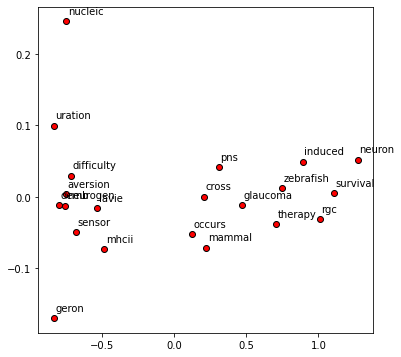

In [93]:
display_pca_scatterplot(model2015_no_start, words=words2show)

# Stemming vs Lemmatizing

In [94]:
proc_doc_porter = get_proc_docs(1993, STARTWORDS, STOPWORDS, use_porter=True)

/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1993/
Number of files: 7
1/7
2/7
3/7
4/7
5/7
6/7
7/7


In [95]:
proc_doc_lemm = get_proc_docs(1993, STARTWORDS, STOPWORDS)

/content/drive/MyDrive/regen_x/data/ocr_paper_COMPREHENSIVE/1993/
Number of files: 7
1/7
2/7
3/7
4/7
5/7
6/7
7/7


In [96]:
num_iterations = 100 
counter = 0
for stemmed, lemmatized in zip(proc_doc_porter[0], proc_doc_lemm[0]):
  if counter == num_iterations:
    break 
  
  print("{} {}\n".format(stemmed, lemmatized))
  counter += 1

journal journal

of of

neurochernistri neurochernistry

raven raven

press press

ltd ltd

new new

york york

1993 1993

intern international

societi society

for for

neurochemistri neurochemistry

amyloid amyloid

precursor precursor

protein protein

is is

synthes synthesized

by by

retin retinal

ganglion ganglion

cell cell

rapidli rapidly

transport transported

to to

the the

optic optic

nerv nerve

plasma plasma

membran membrane

and and

nerv nerve

termin terminal

and and

metabol metabolized

peter peter

j j

morin morin

tcarmela tcarmela

r r

abraham abraham

anil anil

amaratunga amaratunga

trobin trobin

j j

johnson johnson

glenn glenn

huber huber

tjuli tjulie

h h

sandel sandell

and and

richard richard

e e

fine fine

depart department

of of

biochemistri biochemistry

tmedicin tmedicine

and and

j j

anatomi anatomy

boston boston

univers university

school school

of of

medicin medicine

boston boston

and and

enrm enrm

va va

hospit hospita

In [97]:
for stemmed, lemmatized in zip(do_stemming(STARTWORDS), do_lemmatizing(STARTWORDS)):
  print("{} {}".format(stemmed, lemmatized))

Streaming output truncated to the last 5000 lines.
bitempor bitemporal
hindbrain hindbrain
sulfonamid sulfonamide
dopa dopa
hector hector
neglect neglect
car car
diacyl diacyl
naag naag
achr achrs
mario mario
wolffian wolffian
hämäläinen hämäläinen
ium ium
woolf woolf
hydroxyacid hydroxyacid
pde pde
larynx larynx
thiosulph thiosulphate
photosensit photosensitive
fasudil fasudil
tmi tmy
supplementari supplementary
callosum callosum
metabotrop metabotropic
homodim homodimers
l5 l5
stonin stonin
cerebrospin cerebrospinal
globoid globoid
nitron nitrone
pluripot pluripotent
lt lts
fur fur
synapt synaptic
axon axon
bifid bifid
inflammatori inflammatory
gemin geminal
neurosurgeon neurosurgeon
plane plane
ribosom ribosome
balanc balance
cross crossed
complex complex
ichthyosi ichthyosis
reductionist reductionist
prone prone
messag message
knockout knockout
adapt adapting
haemolysin haemolysin
path path
subclaviu subclavius
mlt mlt
ill illness
genet genetics
rt rt
ptsd ptsd
raymond raymond
rost